<a href="https://colab.research.google.com/github/j-ranasinghe/Spam-E-mail-Detection/blob/main/Spam_E_mail_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the libraries

In [260]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Importing the dataset

In [261]:
cols = ['capital_run_length_total','capital_run_length_longest','capital_run_length_average','char_freq_#','char_freq_$','char_freq_!','char_freq_[','char_freq_(','char_freq_;','word_freq_conference','word_freq_table','word_freq_edu','word_freq_re','word_freq_project','word_freq_original','word_freq_meeting','word_freq_cs','word_freq_direct','word_freq_pm','word_freq_parts','word_freq_1999','word_freq_technology','word_freq_85','word_freq_415','word_freq_data','word_freq_857','word_freq_telnet','word_freq_labs','word_freq_lab','word_freq_650','word_freq_george','word_freq_hpl','word_freq_hp','word_freq_money','word_freq_000','word_freq_font','word_freq_your','word_freq_credit','word_freq_you','word_freq_email','word_freq_business','word_freq_free','word_freq_addresses','word_freq_report','word_freq_people','word_freq_will','word_freq_receive','word_freq_mail','word_freq_order','word_freq_internet','word_freq_remove','word_freq_over','word_freq_our','word_freq_3d','word_freq_all','word_freq_address','word_freq_make','class']
df = pd.read_csv('spambase.data' , names= cols )
print(df.head())

   capital_run_length_total  capital_run_length_longest  \
0                      0.00                        0.64   
1                      0.21                        0.28   
2                      0.06                        0.00   
3                      0.00                        0.00   
4                      0.00                        0.00   

   capital_run_length_average  char_freq_#  char_freq_$  char_freq_!  \
0                        0.64          0.0         0.32         0.00   
1                        0.50          0.0         0.14         0.28   
2                        0.71          0.0         1.23         0.19   
3                        0.00          0.0         0.63         0.00   
4                        0.00          0.0         0.63         0.00   

   char_freq_[  char_freq_(  char_freq_;  word_freq_conference  ...  \
0         0.00         0.00         0.00                  0.00  ...   
1         0.21         0.07         0.00                  0.94  ...   

# Data Visualisation

In [262]:
print(df.dtypes) #Check the data type of the attributes


capital_run_length_total      float64
capital_run_length_longest    float64
capital_run_length_average    float64
char_freq_#                   float64
char_freq_$                   float64
char_freq_!                   float64
char_freq_[                   float64
char_freq_(                   float64
char_freq_;                   float64
word_freq_conference          float64
word_freq_table               float64
word_freq_edu                 float64
word_freq_re                  float64
word_freq_project             float64
word_freq_original            float64
word_freq_meeting             float64
word_freq_cs                  float64
word_freq_direct              float64
word_freq_pm                  float64
word_freq_parts               float64
word_freq_1999                float64
word_freq_technology          float64
word_freq_85                  float64
word_freq_415                 float64
word_freq_data                float64
word_freq_857                 float64
word_freq_te

In [263]:
print(df.shape) #Check the shape of the dataset

(4601, 58)


In [264]:
#Check the distribution of the spam vs not-spam 
new_class = pd.Categorical(df["class"])
new_class = new_class.rename_categories(["spam","not_spam"])              
new_class.describe()

,counts,freqs
categories,,
spam,2788,0.605955
not_spam,1813,0.394045


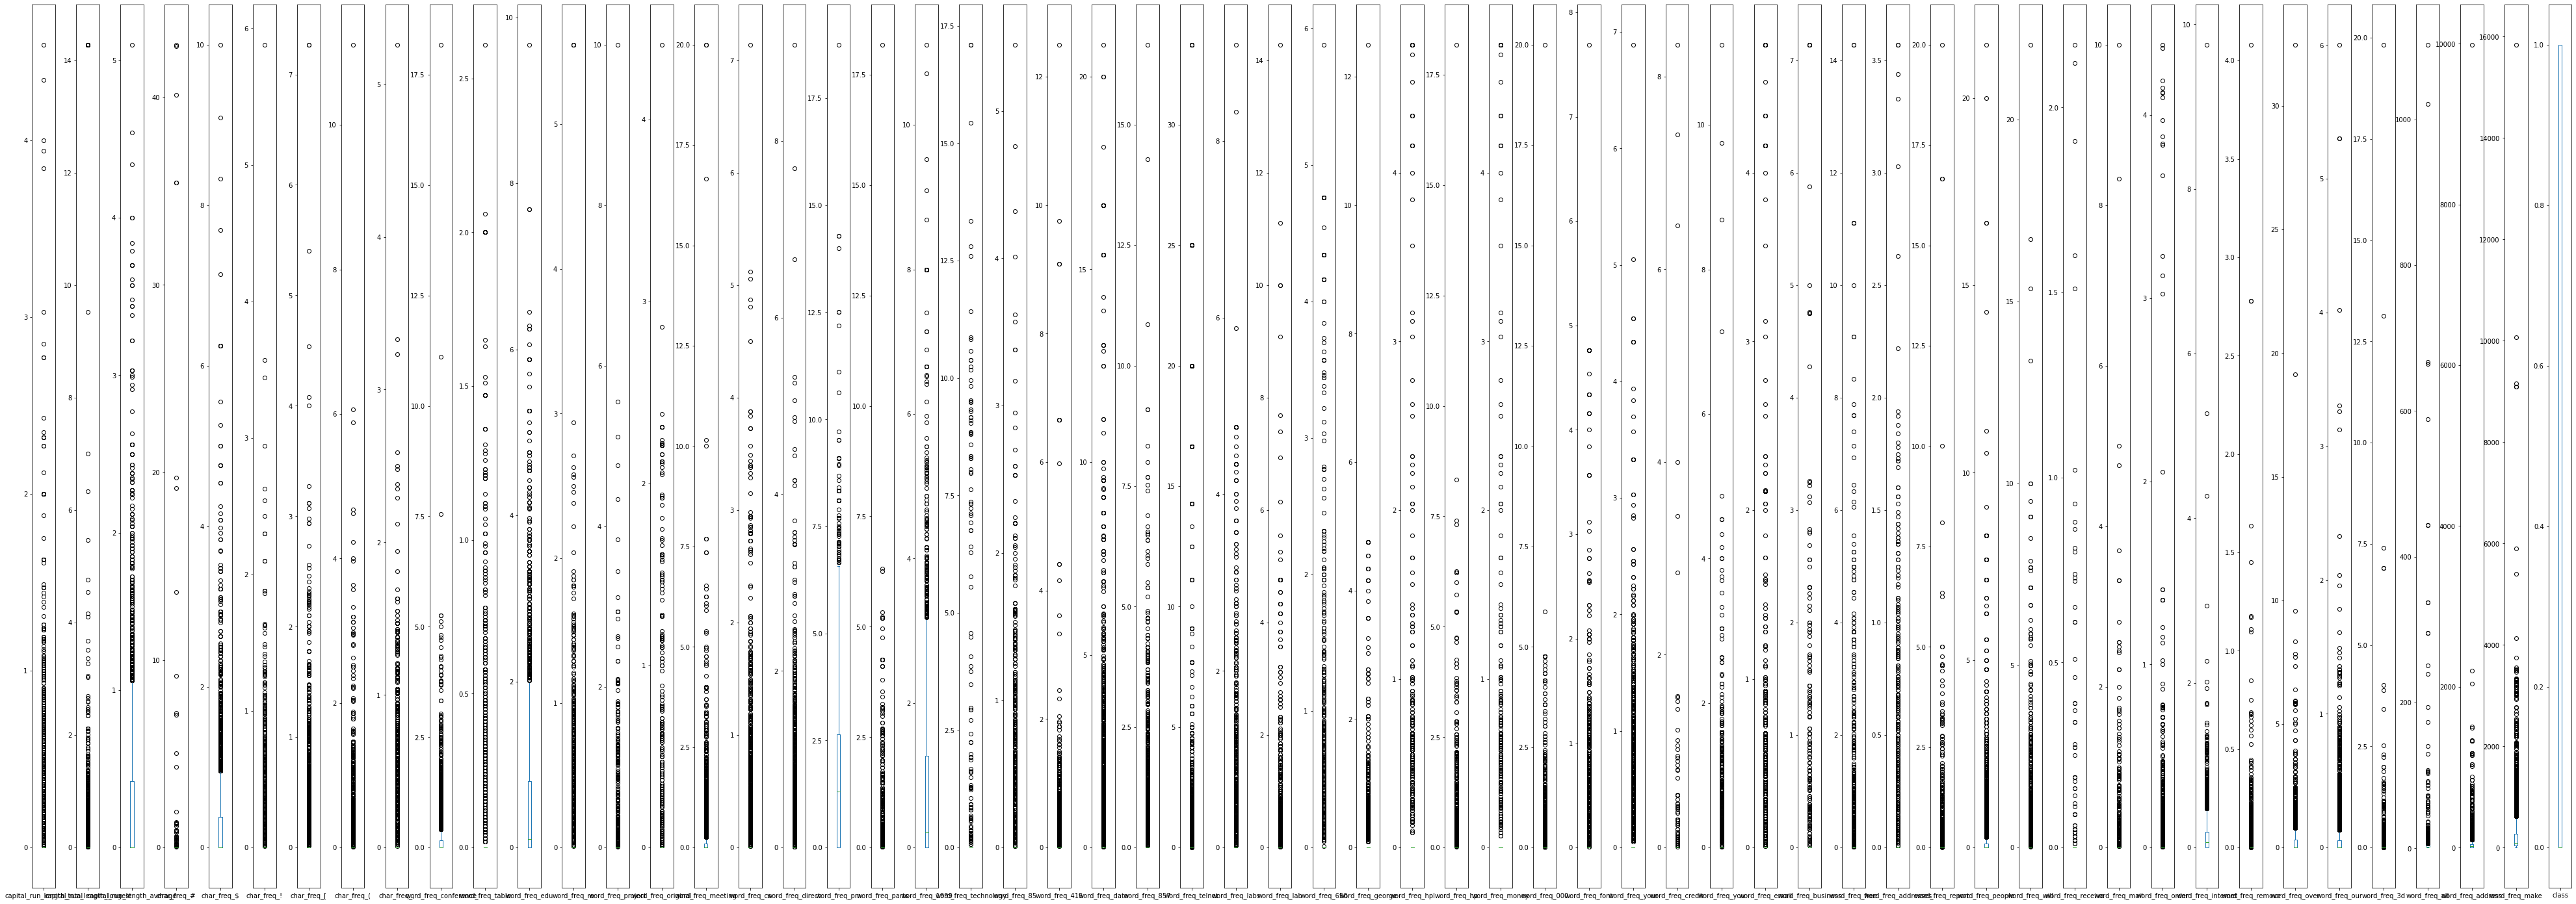

In [265]:
#Boxplot to for outliers
for label in cols[:-1]:
    # for label in range(0,5):
    df.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(70, 25)
    )
    plt.subplots_adjust(wspace=0.9) 
    plt.show()
    break

#Data Cleaning

In [266]:
# Find NaNs and duplicates in df

print('There are {} missing values or NaNs in data.'
      .format(df.isnull().values.sum()))

temp_energy = df.duplicated(keep='first').sum()

print('There are {} duplicate rows in data based on all columns.'
      .format(temp_energy))

df = df.drop_duplicates()   #drop the duplicates

There are 0 missing values or NaNs in data.
There are 391 duplicate rows in data based on all columns.


In [267]:
# extract the features
features = df.drop('class', axis=1)
# extract the labels
labels = df['class']

In [268]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [269]:
# Handle outliers
X_winsorized = winsorize(X_scaled, limits=[0.05, 0.05])

# PCA

In [270]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_winsorized)

In [271]:
print(X_winsorized.shape) # shape of dataframe before applying PCA
print(X_pca.shape) # shape of dataframe after applying PCA

(4210, 57)
(4210, 10)


In [272]:
# handle class imbalance using oversampling technique
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_pca, labels)



---



In [273]:
#K fold validation implementation using 5 splits
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# KNN classification

In [274]:
scores = []
y_true = []
y_pred = []
conf_matrices = []
class_reports = []
execution_times = []

for train, test in kfold.split(X_resampled, y_resampled):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_resampled[train], y_resampled[train])
    y_pred_fold = knn.predict(X_resampled[test])
    y_true_fold = y_resampled[test]

    # record start time
    start_time = time.time()
    score = accuracy_score(y_true_fold, y_pred_fold)
    scores.append(score)
    y_true.extend(y_true_fold)
    y_pred.extend(y_pred_fold)

    # calculate and store accuracy score
    score = accuracy_score(y_resampled[test], y_pred_fold) 
    scores.append(score)
    
    # get the confusion matrix
    conf_matrix = confusion_matrix(y_resampled[test], y_pred_fold)   
    conf_matrices.append(conf_matrix) 

    # get the classification report
    class_report = classification_report(y_resampled[test], y_pred_fold) 
    class_reports.append(class_report)

    # record end time and calculate execution time
    end_time = time.time()
    execution_time = end_time - start_time
    execution_times.append(execution_time)

    # print results for each fold
    print("Fold results:")
    print("Accuracy score:", score)
    print("Confusion matrix:")
    print(conf_matrix)
    print("\nClassification report:")
    print(class_report)
    print("Execution time: {:.2f} seconds".format(execution_time))
    print("="*80)
    print("")

Fold results:
Accuracy score: 0.9210266535044422
Confusion matrix:
[[461  45]
 [ 35 472]]

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       506
           1       0.91      0.93      0.92       507

    accuracy                           0.92      1013
   macro avg       0.92      0.92      0.92      1013
weighted avg       0.92      0.92      0.92      1013

Execution time: 0.01 seconds

Fold results:
Accuracy score: 0.9091806515301086
Confusion matrix:
[[459  48]
 [ 44 462]]

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       507
           1       0.91      0.91      0.91       506

    accuracy                           0.91      1013
   macro avg       0.91      0.91      0.91      1013
weighted avg       0.91      0.91      0.91      1013

Execution time: 0.01 seconds

Fold results:
Accuracy score: 0.9288537549407114
Confusion

# Evaluations

In [275]:
print("Average accuracy score:", sum(scores)/len(scores))
print("Classification report:\n", classification_report(y_true, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
avg_execution_time = sum(execution_times)/len(execution_times)
print("Average execution time: {:.2f} seconds".format(avg_execution_time))

Average accuracy score: 0.9150533187144199
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91      2531
           1       0.91      0.92      0.92      2531

    accuracy                           0.92      5062
   macro avg       0.92      0.92      0.92      5062
weighted avg       0.92      0.92      0.92      5062

Confusion matrix:
 [[2298  233]
 [ 197 2334]]
Average execution time: 0.01 seconds




---



# Decision Tree classification

In [276]:
scores1 = []
y_true1= []
y_pred1 = []
conf_matrices1 = []
class_reports1 = []
execution_times1 = []

# loop to run the Decision tree classification through each fold
for train, test in kfold.split(X_resampled, y_resampled):
    dtc = DecisionTreeClassifier(random_state=42)
    dtc.fit(X_resampled[train], y_resampled[train])
    y_pred_fold = dtc.predict(X_resampled[test])
    y_true_fold = y_resampled[test]

    # record start time
    start_time = time.time()

    score = accuracy_score(y_true_fold, y_pred_fold)
    scores1.append(score)
    y_true1.extend(y_true_fold)
    y_pred1.extend(y_pred_fold)

    # calculate and store accuracy score
    score = accuracy_score(y_resampled[test], y_pred_fold) 
    scores1.append(score)
    
    # get the confusion matrix
    conf_matrix = confusion_matrix(y_resampled[test], y_pred_fold)   
    conf_matrices1.append(conf_matrix) 

    # get the classification report
    class_report = classification_report(y_resampled[test], y_pred_fold) 
    class_reports1.append(class_report)

    # record end time and calculate execution time
    end_time = time.time()
    execution_time = end_time - start_time
    execution_times1.append(execution_time)

    # print results for each fold
    print("Fold results:")
    print("Accuracy score:", score)
    print("Confusion matrix:")
    print(conf_matrix)
    print("\nClassification report:")
    print(class_report)
    print("Execution time: {:.2f} seconds".format(execution_time))
    print("="*80)
    print("")

Fold results:
Accuracy score: 0.8923988153998026
Confusion matrix:
[[446  60]
 [ 49 458]]

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       506
           1       0.88      0.90      0.89       507

    accuracy                           0.89      1013
   macro avg       0.89      0.89      0.89      1013
weighted avg       0.89      0.89      0.89      1013

Execution time: 0.01 seconds

Fold results:
Accuracy score: 0.8993089832181639
Confusion matrix:
[[459  48]
 [ 54 452]]

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       507
           1       0.90      0.89      0.90       506

    accuracy                           0.90      1013
   macro avg       0.90      0.90      0.90      1013
weighted avg       0.90      0.90      0.90      1013

Execution time: 0.01 seconds

Fold results:
Accuracy score: 0.9090909090909091
Confusion

# Evaluations

In [277]:
print("Average accuracy score:", sum(scores1)/len(scores1))
print("Classification report:\n", classification_report(y_true1, y_pred1))
print("Confusion matrix:\n", confusion_matrix(y_true1, y_pred1))
avg_execution_time = sum(execution_times1)/len(execution_times1)
print("Average execution time: {:.2f} seconds".format(avg_execution_time))

Average accuracy score: 0.8962862237552137
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      2531
           1       0.89      0.90      0.90      2531

    accuracy                           0.90      5062
   macro avg       0.90      0.90      0.90      5062
weighted avg       0.90      0.90      0.90      5062

Confusion matrix:
 [[2249  282]
 [ 243 2288]]
Average execution time: 0.01 seconds
